## 1. 큰 그림 보기

### 문제 정의
- 회귀문제
- "음식배달에 걸리는 시간"을 예측하자!

### 성능측정지표
- MAE(Mean Absolute Error)
- Under-prediction의 비율(under-prediction 개수 / 테스트 데이터의 샘플 수)


## 2. 데이터 불러오기

In [87]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [88]:
import pandas as pd

dataset = pd.read_csv('predict_delivery_time.csv')

### 데이터 구조 살펴보기

변수 파악하기
- Restaurant: 음식점 고유의 ID
- Location: 음식점의 위치
- Cuisines: 음식점에서 취급하는 메뉴
- Average_Cost: (고객당) 평균 주문가격
- Minimum_Order: 최소 주문량(또는 금액)
- Rating: 음식점의 평점
- Votes: 평점을 남긴 고객 수
- Reviews: 리뷰 수
- Delivery_Time: 배달시간(예측하고자 하는 값)

In [89]:
dataset.head()

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65


In [90]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094 entries, 0 to 11093
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Restaurant    11094 non-null  object 
 1   Location      11094 non-null  object 
 2   Cuisines      11094 non-null  object 
 3   AverageCost   11094 non-null  object 
 4   MinimumOrder  11094 non-null  int64  
 5   Rating        9903 non-null   object 
 6   Votes         9020 non-null   float64
 7   Reviews       8782 non-null   float64
 8   DeliveryTime  11094 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 780.2+ KB


In [91]:
# 수치형 데이터 타입 변환
dataset['AverageCost'] = pd.to_numeric(dataset['AverageCost'], errors='coerce')
dataset['Rating'] = pd.to_numeric(dataset['Rating'], errors='coerce')

In [92]:
# 수치형 변수 기초통계분석
dataset.describe()

,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
count,11069.000000,11094.000000,9131.00000,9020.000000,8782.000000,11094.000000
mean,200.682085,53.344511,3.61346,244.544457,123.247893,37.056066
std,122.028227,18.551245,0.41434,555.094733,321.025216,12.447496
min,50.000000,0.000000,2.10000,3.000000,1.000000,10.000000
25%,100.000000,50.000000,3.30000,19.000000,7.000000,30.000000
50%,200.000000,50.000000,3.60000,63.000000,26.000000,30.000000
75%,200.000000,50.000000,3.90000,216.000000,91.000000,45.000000
max,950.000000,500.000000,4.90000,9054.000000,6504.000000,120.000000


In [93]:
# 범주형 변수의 종류, 빈도 확인하기
dataset.Location.value_counts()

Mico Layout, Stage 2, BTM Layout,Bangalore          947
DBlock, Sector 63, Noida                            806
Sector 1, Noida                                     791
FTI College, Law College Road, Pune                 584
Delhi UniversityGTB Nagar                           545
Laxman Vihar Industrial Area, Sector 3A, Gurgoan    493
Sector 14, Noida                                    489
Delhi Administration Flats, Timarpur                472
Mumbai Central                                      459
Rmz Centennial, I Gate, Whitefield                  457
Delhi High Court, India Gate                        411
MG Road, Pune                                       402
Nathan Road, Mangaldas Road, Pune                   372
Sandhurst Road, Mumbai CST Area                     370
Sector 3, Marathalli                                366
Majestic                                            334
Delhi Cantt.                                        326
Yerawada, Pune, Maharashtra                     

Saving figure attribute_histogram_plots


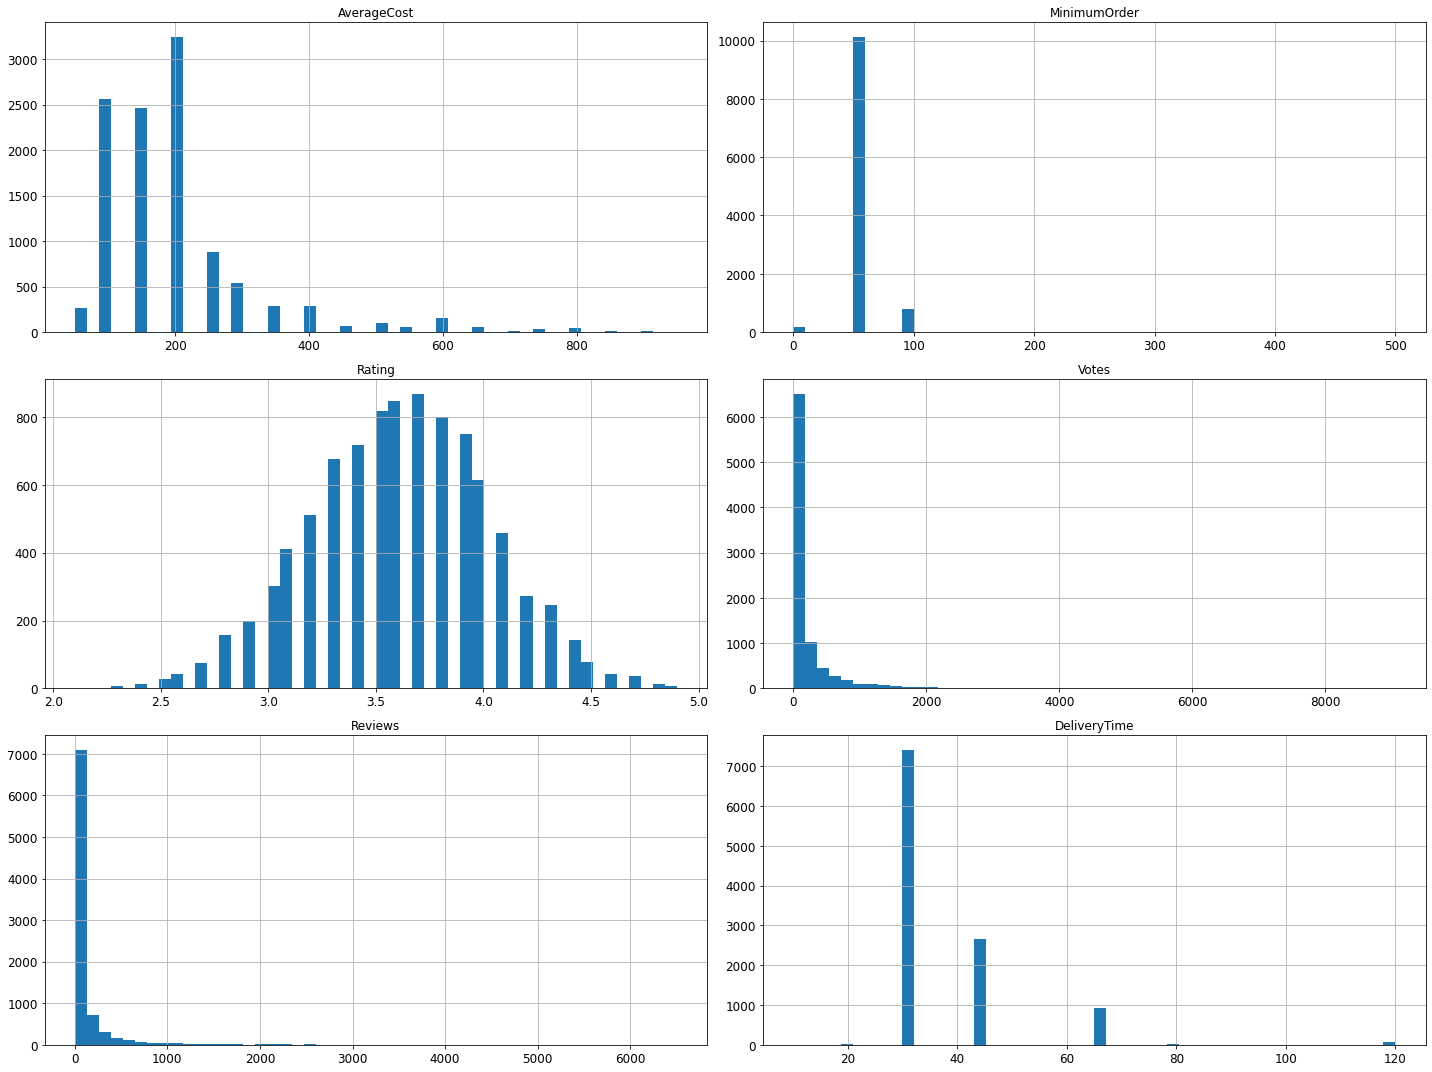

In [94]:
# 히스토그램 그려보기
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### 테스트 데이터셋 분리

In [95]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

## 3. 데이터 이해를 위한 탐색과 시각화

### 상관관계 확인하기

In [96]:
# 데이터 복사본 만들기
dataset = train_set.copy()

In [97]:
corr_matrix = dataset.corr()
corr_matrix["DeliveryTime"].sort_values(ascending=False)

# MinimumOrder, Votes와 강한 양의 상관관계를 갖는 것으로 보인다.

DeliveryTime    1.000000
MinimumOrder    0.257467
Votes           0.211054
AverageCost     0.188807
Reviews         0.185067
Rating          0.128119
Name: DeliveryTime, dtype: float64

Saving figure scatter_matrix_plot


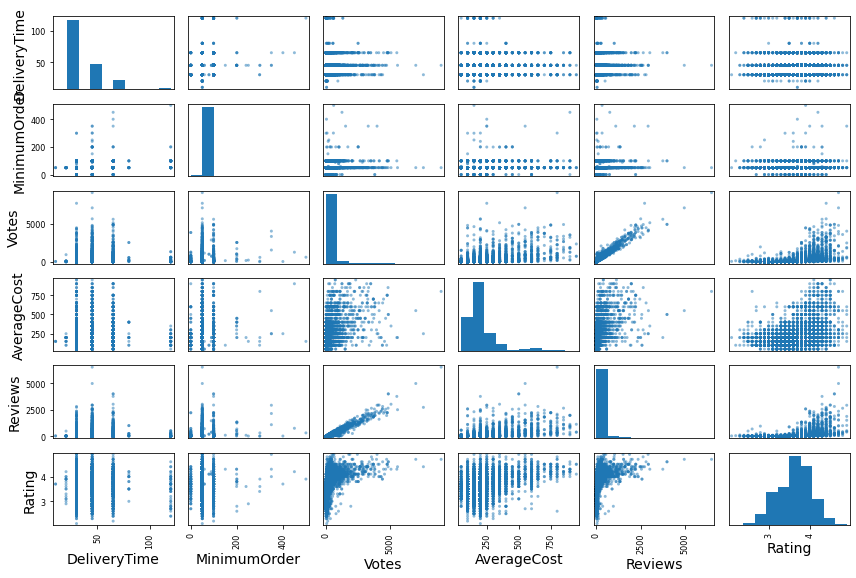

In [98]:
from pandas.plotting import scatter_matrix

attributes = ["DeliveryTime", "MinimumOrder", "Votes",
              "AverageCost", "Reviews", 'Rating']
scatter_matrix(dataset[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure corr_matrix_heatmap


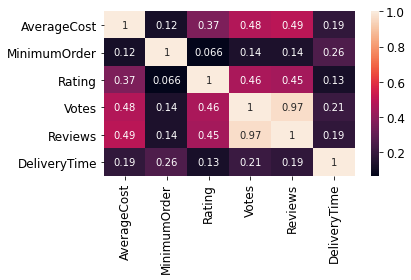

In [99]:
import seaborn as sns

sns.heatmap(corr_matrix, annot=True)
save_fig("corr_matrix_heatmap")

## 4. 머신러닝을 위한 데이터 준비

### 결측치 확인하기

Text(0.5, 1.0, 'Ratio of missing values per columns')

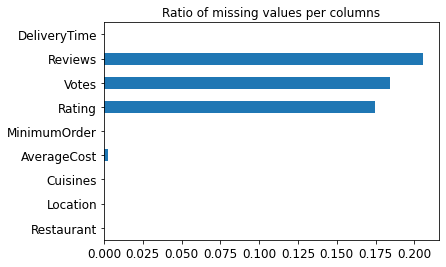

In [100]:
dataset.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [101]:
# 중앙값으로 결측치 채우기
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# 중간값은 수치형 특성에서만 계산될 수 있기 때문에 텍스트 특성을 제외한 복사본을 생성
dataset_num = dataset.drop(["Restaurant", "Location", "Cuisines"], axis=1)

In [102]:
imputer.fit(dataset_num)

X = imputer.transform(dataset_num)

dataset_tr = pd.DataFrame(X, columns=dataset_num.columns,
                          index=dataset.index)
dataset_tr

,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
11025,350.0,50.0,3.8,160.0,73.0,45.0
1684,600.0,50.0,4.0,646.0,370.0,45.0
499,200.0,50.0,3.1,41.0,25.0,45.0
5770,100.0,50.0,4.0,231.0,123.0,45.0
8290,150.0,50.0,3.6,63.0,26.0,30.0
...,...,...,...,...,...,...
5734,200.0,50.0,3.8,116.0,36.0,65.0
5191,200.0,50.0,3.7,132.0,52.0,30.0
5390,200.0,50.0,3.1,5.0,3.0,30.0
860,200.0,50.0,3.4,9.0,2.0,30.0


In [103]:
dataset_tr['Restaurant'] = dataset['Restaurant']
dataset_tr['Location'] = dataset['Location']
dataset_tr['Cuisines'] = dataset['Cuisines']

### 새로운 특성 정의하기
- ReviewRatio: 평점을 남긴 사람들 중 리뷰를 쓴 사람의 비율

In [104]:
dataset_tr['ReviewRatio'] = dataset_tr['Reviews'] / dataset_tr['Votes']

- CuisinesNum: 음식점의 메뉴 개수

In [105]:
dataset_tr['CuisinesNum'] = dataset_tr['Cuisines'].apply(lambda x: len(x.split(', ')))

- Area: Location을 더 큰 범주(주소의 가장 뒤에 나오는 도시 이름)로 분류

In [106]:
dataset_tr['Location'].nunique()

35

In [107]:
dataset_tr['Area'] = dataset_tr['Location'].apply(lambda x: x.split(',')[-1].strip())

In [108]:
# 35개였던 카테고리를 22개로 축소한 효과
dataset_tr['Area'].nunique()

22

In [109]:
corr_matrix = dataset_tr.corr()
corr_matrix["DeliveryTime"].sort_values(ascending=False)

# CuisinesNum은 DeliveryTime과 약한 양의 상관관계가 있는 것으로 보인다.

DeliveryTime    1.000000
MinimumOrder    0.257467
Votes           0.229681
Reviews         0.206077
AverageCost     0.188473
Rating          0.124985
CuisinesNum     0.123196
ReviewRatio    -0.061394
Name: DeliveryTime, dtype: float64

### 변환 파이프라인

In [110]:
# 데이터프레임 준비를 위한 함수들 정의

def get_dummies(df, col):
    return pd.get_dummies(df, columns=[col])

# Cuisines의 메뉴들을 범주형 변수의 형태로 변환
def get_dummies_by_comma(df, col='Cuisines'):
    df = pd.concat([df, df[col].str.get_dummies(", ")], axis=1)
    return df

# CuisinesNum 변수 생성
def get_cuisines_num(df, col='Cuisines'):
    df['CuisinesNum'] = df[col].apply(lambda x: len(x.split(', ')))
    df.drop(col, axis=1, inplace=True)
    return df

# Area 변수 생성
def get_area_from_loc(df, col='Location'):
    df['Area'] = df[col].apply(lambda x: x.split(',')[-1].strip())
    df.drop(col, axis=1, inplace=True)
    return df

# ReviewRatio 변수 생성
def get_review_ratio(df, col1='Votes', col2='Reviews'):
    df['ReviewRatio'] = df[col2] / df[col1]
    return df

def prepare_data(df):
    y = df['DeliveryTime']
    # 예측에 사용되지 않는 열 제거
    df.drop(["Restaurant", "DeliveryTime"], axis=1, inplace=True)
    # 수치형 변수 데이터 타입 변환
    df['AverageCost'] = pd.to_numeric(df['AverageCost'], errors='coerce')
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    return df.pipe(get_dummies_by_comma, "Cuisines").pipe(get_cuisines_num, "Cuisines")\
            .pipe(get_area_from_loc, "Location").pipe(get_review_ratio, "Votes", "Reviews")\
            .pipe(get_dummies, "Area"), y

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 수치형 변수는 중앙값으로 결측치를 채우고 standard scaling
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

num_attribs = ["AverageCost", "MinimumOrder", "Rating", "Votes", "Reviews", "CuisinesNum", "ReviewRatio"]

def full_pipeline(df, num_attribs):
    df_num_tr = num_pipeline.fit_transform(df[num_attribs])
    df_num_tr = pd.DataFrame(df_num_tr, columns=num_attribs, index=df.index)
    new_df = pd.concat([df.drop(num_attribs, axis=1), df_num_tr], axis=1)
    return new_df

In [112]:
X_train, Y_train = prepare_data(train_set)
X_train = full_pipeline(X_train, num_attribs)

## 5. 모델 훈련 및 교차 검증(with MAE)

In [116]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### ExtraTreesRegressor

In [117]:
from sklearn.ensemble import ExtraTreesRegressor

# 129개 column 모두 학습
et_1 = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_1.fit(X_train, Y_train)

et_scores_1 = -1 * cross_val_score(et_1, X_train, Y_train,
                                scoring="neg_mean_absolute_error", cv=10)
display_scores(et_scores_1)

Scores: [5.38150287 4.79453991 4.86797943 5.32700491 5.03166537 5.27394072
 5.45516558 6.13617147 5.35374409 4.99103683]
Mean: 5.261275117622691
Standard deviation: 0.3645265143348207


In [118]:
# 수치형 변수들 + Area(One-hot encoded)만 학습

cols = ['Area_Bangalore',
 'Area_Begumpet',
 'Area_Delhi',
 'Area_Delhi Cantt.',
 'Area_Delhi UniversityGTB Nagar',
 'Area_Electronic City',
 'Area_Gurgaon',
 'Area_Gurgoan',
 'Area_Hyderabad',
 'Area_India Gate',
 'Area_Kolkata',
 'Area_Maharashtra',
 'Area_Majestic',
 'Area_Marathalli',
 'Area_Mumbai',
 'Area_Mumbai CST Area',
 'Area_Mumbai Central',
 'Area_Noida',
 'Area_Pune',
 'Area_Pune University',
 'Area_Timarpur',
 'Area_Whitefield',
 'AverageCost',
 'MinimumOrder',
 'Rating',
 'Votes',
 'Reviews',
 'CuisinesNum',
 'ReviewRatio']

et_2 = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_2.fit(X_train[cols], Y_train)

et_scores_2 = -1 * cross_val_score(et_2, X_train[cols], Y_train,
                                scoring="neg_mean_absolute_error", cv=10)
display_scores(et_scores_2)

Scores: [5.6500911  5.33893613 5.42036807 5.79432444 5.50457737 5.80477844
 5.88572773 6.17048079 5.95763905 5.39614634]
Mean: 5.692306946493703
Standard deviation: 0.2613575554838372


In [119]:
# 수치형 변수들만 학습

num_attribs = ["AverageCost", "MinimumOrder", "Rating", "Votes", "Reviews", "CuisinesNum", "ReviewRatio"]

et_3 = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_3.fit(X_train[num_attribs], Y_train)

et_scores_3 = -1 * cross_val_score(et_3, X_train[num_attribs], Y_train,
                                scoring="neg_mean_absolute_error", cv=10)
display_scores(et_scores_3)

Scores: [4.87376841 4.81882013 4.66681809 5.23101792 4.91141598 4.80120133
 5.03679941 5.38921574 5.23508121 4.75376041]
Mean: 4.971789863133039
Standard deviation: 0.22831779322206017


#### 수치형 변수들만 학습했을 때 모델의 평균 MAE값이 가장 작은 것을 확인하였다.

## 6. 모델 세부 튜닝

In [131]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 150], 
              'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 5, 10],
             'max_depth': [30, 50, 100, None]}
    
et_reg = ExtraTreesRegressor(random_state=42)

grid_search = GridSearchCV(et_reg, param_grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)
grid_search.fit(X_train[num_attribs], Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
             param_grid={'max_depth': [30, 50, 100, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [132]:
grid_search.best_estimator_

ExtraTreesRegressor(max_depth=30, n_estimators=150, random_state=42)

In [135]:
et_tuned = ExtraTreesRegressor(max_depth=30, n_estimators=150, random_state=42)
et_tuned.fit(X_train[num_attribs], Y_train)

et_scores_tuned = -1 * cross_val_score(et_tuned, X_train[num_attribs], Y_train,
                                scoring="neg_mean_absolute_error", cv=10)
display_scores(et_scores_tuned)

Scores: [4.88639247 4.86719877 4.67099023 5.17729911 4.93062081 4.72940078
 5.02906762 5.39430121 5.24980679 4.77645437]
Mean: 4.971153214947988
Standard deviation: 0.22552954048854393


## 테스트셋 평가

In [137]:
X_test, Y_test = prepare_data(test_set)
X_test = full_pipeline(X_test, num_attribs)

In [138]:
pred = et_tuned.predict(X_test[num_attribs])

### MAE

In [139]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test, pred)

9.115545884014619

### Under-prediction 비율

In [140]:
def get_under_pred_ratio(pred, labels):
    cnt = 0
    for i, j in zip(pred, labels):
        if i < j:
            cnt += 1
    return cnt / len(labels)

In [141]:
get_under_pred_ratio(pred, Y_test)

0.23253717890941866

#### 최종적으로, 테스트셋에 대한 모델의 MAE는 9.12, under-prediction 비율은 0.23